Imports!

In [37]:
%matplotlib inline

import h5py

from keras.optimizers import SGD
from keras.utils.visualize_util import to_graph

from IPython.display import SVG

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

from scipy.ndimage.interpolation import rotate

from pprint import pprint

import train
import evaluate
from train import infer_sizes
from models import vggnet16_joint_reg_class

Now load up our data H5 and grab some trained weights for our model.

In [23]:
# Load data and get a model
train_h5_path = '../cache/val-patches-mpii/samples-000001.h5'
train_neg_h5_path = '../cache/val-patches-mpii/negatives.h5'
val_h5_path = '../cache/val-patches-mpii/samples-000001.h5'
val_neg_h5_path = '../cache/val-patches-mpii/negatives.h5'
train_h5 = h5py.File(train_h5_path, 'r')
train_neg_h5 = h5py.File(train_neg_h5_path, 'r')
val_h5 = h5py.File(val_h5_path, 'r')
val_neg_h5 = h5py.File(val_neg_h5_path, 'r')
images, joints, flow = train_h5['images'], train_h5['joints'], train_h5['flow']
train_neg_images, train_neg_flow = train_neg_h5['images'], train_neg_h5['flow']
val_images, val_flow, val_joints = val_h5['images'], val_h5['flow'], val_h5['joints']
val_neg_images, val_neg_flow = val_neg_h5['images'], val_neg_h5['flow']
ds_shape = infer_sizes(train_h5_path)
input_shape = ds_shape['images']
regressor_outputs = ds_shape['joints'][0]

In [5]:
sgd = SGD(lr=0.0001, nesterov=True, momentum=0.9)
# TODO: Everything below this line is definitely broken.
# Need to fix imports, evaluate.py, etc.
model = vggnet16_joint_reg_class(input_shape, regressor_outputs, sgd, 'glorot_normal')
model.load_weights('../cache/keras-checkpoints/model-iter-4320-r869001.h5')

In [19]:
model.input_config

[{'dtype': 'float', 'input_shape': (6, 224, 224), 'name': 'images'}]

## Visualising network architecture

Start by doing a basic visualisation of our model and inspecting the shape of our data.

# Data shapes
images: (25488, 6, 224, 224)
flow: (25488, 12)
joints: (25488, 12)
validation images: (25488, 6, 224, 224)
validation flow: (25488, 2, 224, 224)
validation joints: (25488, 12)

# Network


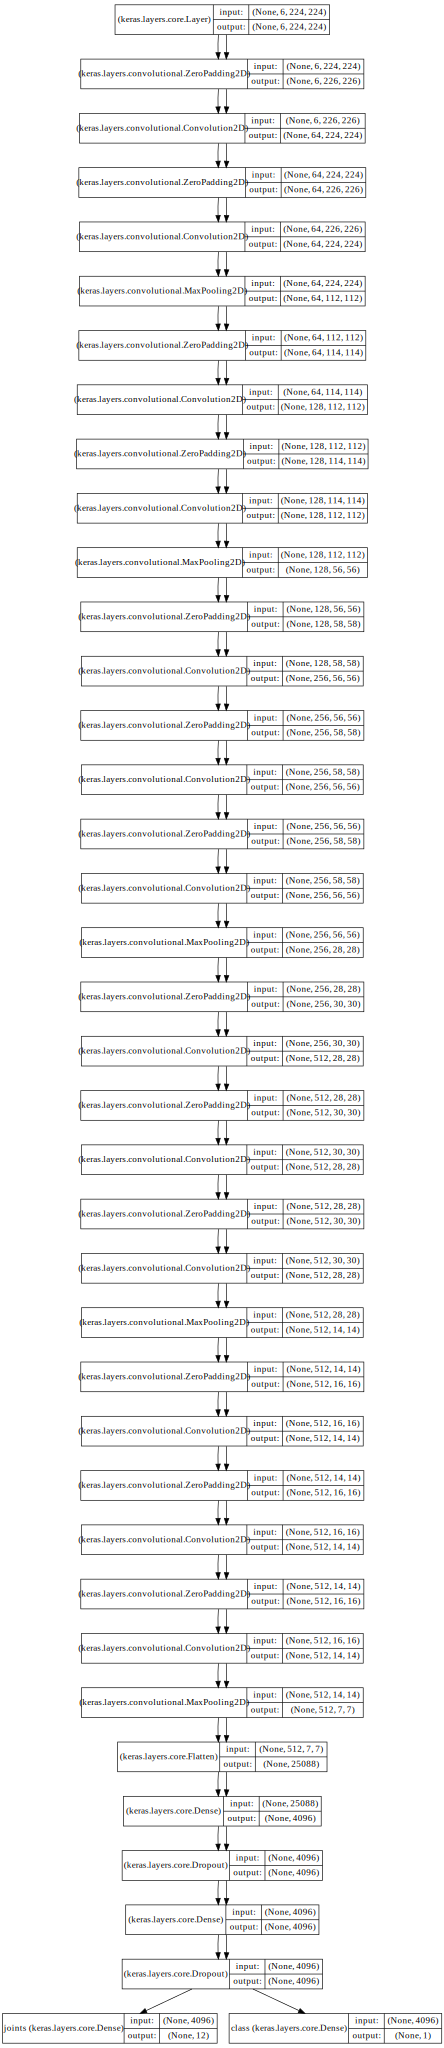

In [20]:
print '# Data shapes'
print 'images:', images.shape
print 'flow:', flow.shape
print 'joints:', joints.shape
print 'validation images:', val_images.shape
print 'validation flow:', val_flow.shape
print 'validation joints:', val_joints.shape
print
print '# Network'
SVG(to_graph(model, show_shape=True).create(prog='dot', format='svg'))

## Visualising the training set (no predictions)

Now write some functions to look at our data and also a few utilities for doing forward prop. These will be useful for inspecting activations and gradients, as well as verifying that I've written what I wanted to write to the file.

Note that some of these images will look weird because they've been padded (where necessary) with their edge pixel values. This is true of the flow as well.

Ground truth (NOT prediction) 20655


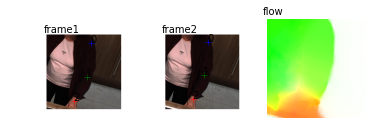

Ground truth (NOT prediction) 12888


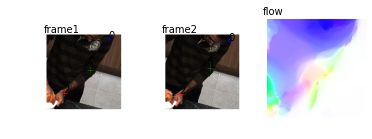

Ground truth (NOT prediction) 3396


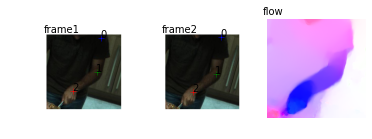

Validation negative 2342


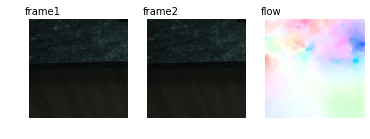

Validation negative 712


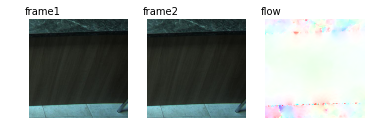

Validation negative 4670


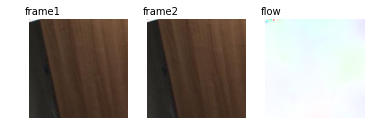

In [24]:
def _reshape_im(im):
    # images are stored channels-first, but numpy expects
    # channels-last
    return np.transpose(im, axes=(1, 2, 0))

def _vis_flow(flow):
    # clean visualisation of flow with angle of movement as
    # hue, magnitude as saturation and a constant V of 1
    x, y = flow
    # normed-log makes things stand out quite a bit
    mags = np.log(np.sqrt(x**2 + y**2) + 1)
    norm_mags = mags / max(mags.flatten())
    angles = (np.arctan2(x, y) + np.pi) / (2 * np.pi)
    ones = np.ones_like(angles)
    hsv = np.stack((angles, norm_mags, ones), axis=2)
    return hsv_to_rgb(hsv)

def _label_to_coords(label):
    return label.reshape((-1, 2))

def _plot_coords(coords):
    # plot a label corresponding to a flattened joint vector
    for idx, coord in enumerate(coords):
        plt.plot(coord[0], coord[1], marker='+')
        plt.text(coord[0], coord[1], str(idx))

def show_datum(image, flow, label=None):
    # First frame
    im1 = _reshape_im(image[:3])
    plt.subplot(131)
    plt.imshow(im1)
    plt.axis('off')
    plt.text(-10, -10, 'frame1')
    
    if label is not None:
        coords = _label_to_coords(label)
        first_coords = coords[:len(coords)//2]
        _plot_coords(first_coords)
    
    # Second frame
    im2 = _reshape_im(image[3:6])
    plt.subplot(132)
    plt.imshow(im2)
    plt.axis('off')
    plt.text(-10, -10, 'frame2')
    
    if label is not None:
        second_coords = coords[len(coords)//2:]
        _plot_coords(second_coords)
    
    # Optical flow
    if flow is not None:
        im_flow = _vis_flow(flow)
        plt.subplot(133)
        plt.imshow(im_flow)
        plt.axis('off')
        plt.text(-10, -10, 'flow')

    plt.show()

for i in np.random.permutation(len(joints))[:3]:
    # Just visualise the input data so that I know I'm writing it out correctly
    print 'Ground truth (NOT prediction)', i
    show_datum(images[i], flow[i], joints[i])

for i in np.random.permutation(len(val_neg_images))[:3]:
    print 'Validation negative', i
    show_datum(val_neg_images[i], val_neg_flow[i])

## RGB results

Now we can try evaluating the CNN on some of our training and evaluation data, just to see whether it's learning anything useful.

In [33]:
def evaluate_on_datum(data, model=model):
    mps = train.read_mean_pixels('../cache/mean_pixel.mat')
    data = train.sub_mean_pixels(mps, data)
    return model.predict(data)

In [ ]:
print('# Validation images')
# Change the [:10] up to [:100] or [:500] if you want to see more predictions, then hit
# shift+enter to re-evaluate the cell (may need to use Kernel -> Restart & Run All if
# the interpreter has shut down for some reason and you get an exception as a result)
for i in np.random.permutation(len(val_joints))[:50]:    
    print 'Validation datum', i
    preds = evaluate_on_datum({'images': val_images[i:i+1]})
    show_datum(val_images[i], val_flow[i], label=preds['joints'][0])
    pprint(preds)
    
print('\n\n\n# Validation negatives')
for i in np.random.permutation(len(val_neg_images))[:50]:    
    print 'Validation negative', i
    preds = evaluate_on_datum({'images': val_neg_images[i:i+1]})
    show_datum(val_neg_images[i], val_neg_flow[i], label=preds['joints'][0])
    pprint(preds)
    
print('\n\n\n# Training images')
for i in np.random.permutation(len(joints))[:10]:
    print 'Training datum', i
    preds = evaluate_on_datum({'images': images[i:i+1]})
    show_datum(images[i], flow[i], label=preds['joints'][0])
    pprint(preds)

# IGNORE RESULTS BELOW HERE

They haven't been updated yet.

## RGB-only results

Here we are attempting to predict a complete half-body pose using *only* stacked RGB data from the two frames as input (no flow).

In [ ]:
rgb_input_shape, _, _ = infer_sizes(train_h5_path, use_rgb=True, use_flow=False)
rgb_model = vggnet16_regressor_model(rgb_input_shape, reg_outs, sgd, 'glorot_normal')
rgb_model.load_weights('../cache/keras-checkpoints/model-iter-2160-r162528.h5')

In [ ]:
print('# Validation images')
for i in np.random.permutation(len(val_joints))[:3]:    
    print 'Validation datum', i
    pred_joints = evaluate_on_datum(image=val_images[i], flow=None, model=rgb_model)
    show_datum(val_images[i], None, pred_joints)
    
print('# Training images')
for i in np.random.permutation(len(joints))[:3]:
    print 'Training datum', i
    pred_joints = evaluate_on_datum(image=images[i], flow=None, model=rgb_model)
    show_datum(images[i], None, pred_joints)

## Flow-only results (just predicting wrists)

The opposite experiment to the previous one, where we only use flow between the two frames. This time, we're only regressing wrists, since other parts don't move as frequently.

In [ ]:
flow_input_shape, _, _ = infer_sizes(train_h5_path, use_rgb=False, use_flow=True)
train_wrists = train_h5['/wrists']
val_wrists = val_h5['/wrists']
flow_model = vggnet16_regressor_model(flow_input_shape, train_wrists.shape[1], sgd, 'glorot_normal')
flow_model.load_weights('../cache/keras-checkpoints/model-iter-4272-r077347.h5')

In [ ]:
print('# Validation images')
for i in np.random.permutation(len(val_wrists))[:3]:    
    print 'Validation datum', i
    pred_wrists = evaluate_on_datum(image=None, flow=val_flow[i], model=flow_model)
    # Only show images so that we can see how close to GT we are;
    # images aren't actually fed into the model
    show_datum(val_images[i], val_flow[i], pred_wrists)
    
print('# Training images')
for i in np.random.permutation(len(train_wrists))[:3]:
    print 'Training datum', i
    pred_wrists = evaluate_on_datum(image=None, flow=flow[i], model=flow_model)
    # Only show images so that we can see how close to GT we are;
    # images aren't actually fed into the model
    show_datum(images[i], flow[i], pred_wrists)

Now we'll do some rotations to check whether the regressor is robust to different wrist locations.

In [ ]:
def rotate_image(image, angle):
    # See bit.ly/1StivtV for explanation of mode parameter,
    # which controls padding method
    assert image.shape[0] < 10, "Channels should be first"
    # transpose into channel-first form
    transposed = image.transpose((1, 2, 0))
    rotated = rotate(
        transposed, angle, mode='nearest', reshape=False
    )
    untransposed = rotated.transpose((2, 0, 1))
    return untransposed

def mat_vec_prod(mat, vecs):
    """Takes an m*n transformation matrix and a p*q*n matrix
    of n-dimensional vectors and does a matrix-vector multiply
    between the first matrix and each vector in the second
    matrix."""
    shaped_vecs = vecs.reshape((vecs.shape[0] * vecs.shape[1], vecs.shape[2]))
    result = np.dot(mat, shaped_vecs.T).T
    return result.reshape(vecs.shape)

def rotate_flow(flow, angle):
    rotate_tform = np.array([
        [np.cos(angle),  np.sin(angle)],
        [-np.sin(angle), np.cos(angle)]
    ]).reshape((1, 1, 2, 2))
    assert flow.shape[0] < 10, "u, v axis should be first"
    rotated_mat = rotate_image(flow, angle)
    # tanspose into channel-last form
    trans_flow = rotated_mat.transpose((1, 2, 0))
    # remember that flow vectors are in form [x, y], in image
    # coordinates (so x increases from left to right and y
    # increases from top to bottom). This is why we rotate
    # clockwise by angle instead of anti-clockwise by angle.
    rotated_vecs = mat_vec_prod(rotate_tform, trans_flow)
    return rotated_vecs.transpose((2, 0, 1))
    
# Test rotations for RGB
angle = 90
test_image = images[1029, :3, :, :]
plt.subplot(121)
plt.imshow(test_image.transpose((1, 2, 0)))
plt.axis('off')
plt.subplot(122)
plt.imshow(rotate_image(test_image, angle).transpose((1, 2, 0)))
plt.axis('off')
plt.show()

# Test rotations for flow
test_flow = flow[1029]
rotated_flow = rotate_flow(test_flow, angle)
plt.subplot(121)
plt.imshow(_vis_flow(test_flow))
plt.axis('off')
plt.subplot(122)
plt.imshow(_vis_flow(rotated_flow))
plt.axis('off')
plt.show()

In [ ]:
print('# Validation images')
for i in np.random.permutation(len(val_wrists))[:3]:    
    deg = np.random.choice([-90, -60, 60, 90])
    print 'Validation datum', i, '(rotated CCW by {} deg)'.format(deg)
    rot_flow = rotate_flow(val_flow[i], deg)
    rot_im = rotate_image(val_images[i], deg)
    pred_wrists = evaluate_on_datum(image=None, flow=rot_flow, model=flow_model)
    # Only show images so that we can see how close to GT we are;
    # images aren't actually fed into the model
    show_datum(rot_im, rot_flow, pred_wrists)

## Measuring accuracy

### RGB-only model (PCP, pixel threshold accuracy)

In [ ]:
def plot_acc(thresholds, accs, plot_title, labels):
    if not isinstance(accs, list) and accs.ndim == 1:
        accs_list = [accs]
        label_list = [labels]
    else:
        accs_list = np.array(accs).T
        label_list = labels
    for acc, label in zip(accs_list, label_list):
        plt.plot(thresholds, acc, label=label)
    plt.ylim((0, 1))
    plt.xlim((min(thresholds), max(thresholds)))
    plt.ylabel('accuracy')
    plt.xlabel('threshold (px)')
    plt.title(plot_title)
    plt.legend()
    plt.show()

test_in_vals = np.linspace(0, 50, 100)
plot_acc(test_in_vals, -1 / (test_in_vals + 1) + 1, 'Example plot', 'foo')

In [ ]:
mp_path = '../cache/mean_pixel.mat'
all_predictions = evaluate.get_predictions(rgb_model, mp_path, images=val_images, batch_size=48)

In [ ]:
labels = [
    'shoulder 1',
    'elbow 1',
    'wrist 1',
    'shoulder 2',
    'elbow 2',
    'wrist 2'
]
all_gts = evaluate.label_to_coords(np.array(val_joints))
thresholds = np.linspace(0, 70, 100)
accs = evaluate.score_predictions_acc(all_gts, all_predictions, thresholds)
plot_acc(thresholds, accs, 'RGB model accuracy (all joints)', labels)

In [ ]:
limbs = [
    (0, 1),
    (1, 2),
    (3, 4),
    (4, 5)
]
limb_names = [
    'uarm1',
    'farm1',
    'uarm2',
    'farm2'
]

pcps = evaluate.score_predictions_pcp(all_gts, all_predictions, limbs)

def show_pcp(pcps, limb_names):
    fmt = lambda s: '{:>20}'.format(s)
    print(fmt('limb name') + ''.join(fmt(l) for l in limb_names))
    print(fmt('pcp') + ''.join(fmt(p) for p in pcps))
    
show_pcp(pcps, limb_names)

### Flow-only model (pixel threshold accuracy)

In [ ]:
flow_predictions = evaluate.get_predictions(flow_model, mp_path, flows=val_flow, batch_size=48)

In [ ]:
flow_labels = [
    'wrist 1',
    'wrist 2'
]
# There's no PCP here because we only have disconnected joints
flow_accs = evaluate.score_predictions_acc(all_gts[:, (2, 5)], flow_predictions, thresholds)
plot_acc(thresholds, flow_accs, 'Flow model accuracy (wrist only)', flow_labels)